In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import utils
import skutils
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

seed = 47

# Use ggplot style
plt.style.use('ggplot')

%matplotlib inline

/home/stevie/Develop/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
big = train

big.species = big.species.astype('category')
big.species = big.species.cat.codes

# big = pd.get_dummies(big, sparse=True)

big.species

0       3
1      49
2      65
3      94
4      84
5      40
6      54
7      78
8      53
9      89
10     98
11     16
12     74
13     50
14     58
15     31
16     43
17      4
18     75
19     44
20     83
21     84
22     13
23     66
24     15
25      6
26     73
27     22
28     73
29     31
       ..
960    85
961    89
962    94
963    45
964    48
965    86
966    81
967    14
968     4
969    77
970    56
971    82
972     2
973    85
974    70
975    88
976     0
977    75
978    14
979    86
980    81
981    97
982    70
983    72
984    34
985    40
986     5
987    11
988    78
989    50
Name: species, dtype: int8

In [4]:
def transform(data):
    ID = data.id
    X = data.drop(['species', 'id'], axis=1)
    y = data['species']
    return ID, X, y

ID, X, y = transform(big)

In [5]:
def addZeroColumn(df, colName):
    df.loc[df[colName] < 0.01, colName + '_is_small'] = 1
    df[colName + '_is_small'].fillna(0, inplace=True)

def addZeroColumns(df, colBaseName):
    for n in range(1,65):
        addZeroColumn(df, colBaseName + str(n))
        
addZeroColumns(X, 'margin')
addZeroColumns(X, 'texture')

In [6]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, cohen_kappa_score, auc, make_scorer, average_precision_score, f1_score, brier_score_loss, log_loss
from sklearn.pipeline import Pipeline

classifiers = {
        "LR": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1) },
        "LR_std": { "f": Pipeline([
                    ('scaling', StandardScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "LR_mm": { "f": Pipeline([
                    ('scaling', MinMaxScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "LR_rob": { "f": Pipeline([
                    ('scaling', RobustScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "RF": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1) },
        "RF_std": { "f": Pipeline([
                    ('scaling', StandardScaler()),
                    ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
                ]) },
        "RF_mm": { "f": Pipeline([
                    ('scaling', MinMaxScaler()),
                    ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
                ]) },
        "RF_rob": { "f": Pipeline([
                    ('scaling', RobustScaler()),
                    ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
                ]) }
}  

classifiers = {
    "LR_std": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
            ]) },
    "RF": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1) },
}   

measures = {
    'pre': precision_score,
    #'avg': average_precision_score,
    'rec': recall_score,
    'acc': accuracy_score,
    'ck': cohen_kappa_score,
    'f1': f1_score,
    #'ll': log_loss,
    #'br': brier_score_loss
}

In [26]:
def test_split(test_size):
    sss = StratifiedShuffleSplit(10, test_size=test_size, random_state=seed)
    
    for clf in classifiers.keys(): 
        c = classifiers[clf]   
        for meas in measures.keys():
            c[meas] = []

    for train_index, test_index in sss.split(X, y):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        
        #print(np.asarray(y_test))
        
        #print(y_test)

        for clf in classifiers.keys():                    
            c = classifiers[clf]    
            c["f"].fit(X_train, y_train)
            y_pred = c["f"].predict(X_test)
            
            #y_test = y_test.asarray(y_test) # [0, 1, 2, 2, 2]
            y_pred = np.asarray(y_pred) #[0, 0, 2, 2, 1]

            #print(clf)
            print(classification_report(y_test, y_pred))
            #print(y_test)
            #print(y_pred)

            for meas in measures.keys():
                m = measures[meas]

                if (meas != 'ck' and meas != 'acc' and meas != 'br'):
                    c[meas].append(m(y_test, y_pred, average='macro'))
                elif (meas == 'll'):
                    c[meas].append(m(y_test, y_pred, labels=y_test))
                else:
                    c[meas].append(m(y_test, y_pred))
    
    return classifiers
               
cl = []
    
#for i in range(1,9):
#    cl.append(test_split(0.1 + 0.1 * i))
cl.append(test_split(0.8))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         8
          1       1.00      1.00      1.00         8
          2       0.80      1.00      0.89         8
          3       1.00      1.00      1.00         8
          4       1.00      1.00      1.00         8
          5       1.00      1.00      1.00         8
          6       1.00      1.00      1.00         8
          7       0.67      1.00      0.80         8
          8       1.00      1.00      1.00         8
          9       1.00      1.00      1.00         8
         10       0.78      0.88      0.82         8
         11       1.00      0.75      0.86         8
         12       1.00      0.75      0.86         8
         13       1.00      0.75      0.86         8
         14       0.73      1.00      0.84         8
         15       1.00      1.00      1.00         8
         16       0.89      1.00      0.94         8
         17       1.00      0.75      0.86   

In [25]:
cl

#results

[{'LR_std': {'acc': [0.91919191919191923,
    0.93813131313131315,
    0.93181818181818177,
    0.9255050505050505,
    0.94318181818181823,
    0.95454545454545459,
    0.94696969696969702,
    0.95707070707070707,
    0.93560606060606055,
    0.94444444444444442],
   'ck': [0.91836734693877553,
    0.9375,
    0.93112244897959184,
    0.92474489795918369,
    0.94260204081632648,
    0.95408163265306123,
    0.9464285714285714,
    0.95663265306122447,
    0.93494897959183676,
    0.94387755102040816],
   'f': Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='multinomial',
             n_jobs=-1, penalty='l2', random_state=None, solver='lbfgs',
             tol=0.0001, verbose=0, warm_start=False))]),
   'f1': [0.91596260731967649,
    0.93672918641958902,
    0.93009707965848321,
    0.92369957184

              f1        ck       pre       acc       rec
LR_std  0.937735  0.939031  0.949826  0.939646  0.939646
RF      0.864760  0.867602  0.885380  0.868939  0.868939
test_size: 0.2


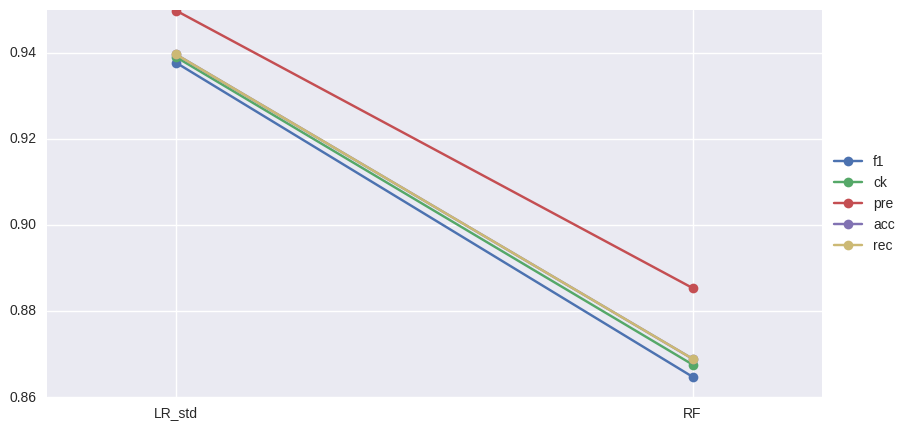

IndexError: list index out of range

In [27]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(0,8):
    results = pd.DataFrame(columns=measures.keys())

    # Evaluate each model in classifiers
    for model in classifiers.keys():
        results.loc[model] = [np.mean(cl[i][model][measure]) for measure in measures.keys()]

    print(results)
        
    figsize(10, 5)
    ax = plt.subplot(111)

    ind = np.arange(results.shape[0])
    width = 0.2
    l = ax.plot(ind, results, "-o")
    plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(results.index)
    
    print("test_size: " + str(0.1 + 0.1 * (i + 1)))
    plt.show()